In [1]:
import ast
# Импорт стандартной библиотеки
import os
import warnings
from IPython.display import IFrame
import random
import string
import re
import warnings
warnings.filterwarnings("ignore")
# Импорт библиотек для научных вычислений
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt


import plotly.express as px
import plotly.graph_objects as go
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from datetime import datetime
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


# Импорт расчета статистик и моделей машинного обучения
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, confusion_matrix, recall_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV,
    KFold,
    train_test_split
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    FunctionTransformer
)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from catboost import CatBoostClassifier


# Установка опции для отображения всех столбцов
pd.options.display.max_columns = None

# Константы
LINE_1 = '-'*125
RANDOM_STATE = 45
TEST_SIZE = 0.25

### Введение


В нашем распоряжении данные компании с информацией о покупках клиентов по дням и по товарам, данные о рассылках, которые были отправлены клиентам и целевой признак о факте совершения покупки в целевом периоде. Наша цель проанализировать эти данные и при помощи моделей машинного обучения и решить задачу:

предсказать вероятность покупки в течение 90 дней.
План нашего проекта такой:

1) Прочитаем данные, изучим проблемы в них

2) В случае наличия проблем, обработаем их

3) Объеденим датасеты и выведем новые признаки

3) Проведем исследовательский анализ данных и изучим информацию

4) Подготовим данные для обучения модели, создав пайплайн

5) Обучим модели, найдем лучшую, расчитаем интересующую нас метрику

6) Сделаем выводы

## 1. Загрузка данных



Загрузим наши датасеты, перед этим создадим для этого функцию:

In [2]:
def load_data(file_path, sep=',', decimal='.', date_columns=None):
    try:
        print(f'Загрузка данных из локального файла: {file_path}')
        return pd.read_csv(file_path, sep=sep, decimal=decimal, parse_dates=date_columns)
    except Exception as e:
        # Если возникла ошибка, выводим сообщение об ошибке
        print('Загрузка произошла с ошибкой')
        error_message = str(e)
        print(error_message)

In [3]:
# Путь к локальному файлу и URL удаленного файла
local_file_path_mess = r'C:\Users\Александр\PycharmProjects\JupyterProject\apparel_messages.csv'
local_file_path_purch = r'C:\Users\Александр\PycharmProjects\JupyterProject\apparel_purchases.csv'
local_target = r'C:\Users\Александр\PycharmProjects\JupyterProject\apparel_target_binary.csv'

# Загрузка данных
data_apparel_messages = load_data(local_file_path_mess, date_columns=['date', 'created_at'])
data_apparel_purchases = load_data(local_file_path_purch, date_columns=['date'])
data_target = load_data(local_target)

Загрузка данных из локального файла: C:\Users\Александр\PycharmProjects\JupyterProject\apparel_messages.csv
Загрузка данных из локального файла: C:\Users\Александр\PycharmProjects\JupyterProject\apparel_purchases.csv
Загрузка данных из локального файла: C:\Users\Александр\PycharmProjects\JupyterProject\apparel_target_binary.csv


Данные загружены - отлично! Изучим данные, создав функцию, чтобы не дублировать код:

In [4]:
def data_head_info(data):
    display(data.head())
    display(data.info())

In [5]:
data_head_info(data_apparel_messages)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


None

In [6]:
data_head_info(data_apparel_purchases)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


None

In [7]:
data_head_info(data_target)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

Данные загружены и изучены. На первый взгляд проблем с ними нет. Разве что есть пропуски в колонке с информацией о категориях. Для этого предобработаем таблицу с информацией о заказах в следующем пункте.

## 2. Предобработка данных

Изучим и изменим нашу таблицу с информацией о заказах более детально. Для этого сначала отделим первую категорию в списке и выделим в отдельной колонке, а пропуски заполним значением "NO":

In [8]:
data_apparel_purchases['category_ids'] = data_apparel_purchases['category_ids'].apply(lambda x:ast.literal_eval(x))
data_apparel_purchases['cat_value'] = data_apparel_purchases['category_ids'].apply(lambda x: x[0] if x else 'NO')
data_apparel_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,cat_value
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4


Исключим столбец с первоначальными категоориями из датасета:

In [9]:
data_apparel_purchases= data_apparel_purchases.drop(['category_ids'], axis=1)

In [10]:
data_head_info(data_apparel_purchases)

,client_id,quantity,price,date,message_id,cat_value
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4
2,1515915625471138230,1,6499.0,2022-05-16,1515915625471138230-4437-6282242f27843,4
3,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4
4,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   client_id   202208 non-null  int64         
 1   quantity    202208 non-null  int64         
 2   price       202208 non-null  float64       
 3   date        202208 non-null  datetime64[ns]
 4   message_id  202208 non-null  object        
 5   cat_value   200944 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


None

Расчитаем стоимость заказа, выделив отедльную колонку order_price:

In [11]:
data_apparel_purchases['order_price'] = data_apparel_purchases['price']*data_apparel_purchases['quantity']
data_apparel_purchases.head()

,client_id,quantity,price,date,message_id,cat_value,order_price
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,1999.0
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,2499.0
2,1515915625471138230,1,6499.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,6499.0
3,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,4999.0
4,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,4999.0


И, наконец, преобразуем наш датасет, собрав все более кучно. Сгруппируем датасет, суммировав количество и сумму по одному киленту-ид-сообщения. Для стоимости заказа будем использовать среднее и сумму, для количества товаров будем использовать сумму.

In [12]:
grouped_purchases = data_apparel_purchases.groupby(['client_id', 'message_id','date', 'cat_value']).agg({'order_price':['mean', 'sum'], 'quantity':['sum']}).reset_index()


Переименуем колонки после группировки:

In [13]:
grouped_purchases.columns = ['client_id', 'message_id', 'date', 'cat_value', 'order_price_avg', 'order_price_sum', 'quantity']
data_head_info(grouped_purchases)

,client_id,message_id,date,cat_value,order_price_avg,order_price_sum,quantity
0,1515915625468060902,1515915625468060902-4617-6290657dac196,2022-05-27,4,999.000000,6993.0,7
1,1515915625468061003,1515915625468061003-9148-63b54b04855a4,2023-01-04,4,2319.285714,16235.0,7
2,1515915625468061099,1515915625468061099-4439-62834141aa538,2022-05-17,4,299.000000,299.0,1
3,1515915625468061100,1515915625468061100-14623-65c5c55eeb9e0,2024-02-10,4,1049.000000,2098.0,2
4,1515915625468061170,1515915625468061170-11144-641ad2cda77a2,2023-03-26,2,2699.000000,5398.0,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69392 entries, 0 to 69391
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   client_id        69392 non-null  int64         
 1   message_id       69392 non-null  object        
 2   date             69392 non-null  datetime64[ns]
 3   cat_value        69392 non-null  object        
 4   order_price_avg  69392 non-null  float64       
 5   order_price_sum  69392 non-null  float64       
 6   quantity         69392 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 3.7+ MB


None

Отсуртируем данные по клиенту и дате и добавим столбец с информацией о количестве дней до следующего заказа, если он был:

In [14]:
grouped_purchases = grouped_purchases.sort_values(by=['client_id', 'date'])
grouped_purchases['days_to_next_order'] = grouped_purchases.groupby(['client_id'])['date'].diff().dt.days
data_head_info(grouped_purchases)

,client_id,message_id,date,cat_value,order_price_avg,order_price_sum,quantity,days_to_next_order
0,1515915625468060902,1515915625468060902-4617-6290657dac196,2022-05-27,4,999.000000,6993.0,7,NaN
1,1515915625468061003,1515915625468061003-9148-63b54b04855a4,2023-01-04,4,2319.285714,16235.0,7,NaN
2,1515915625468061099,1515915625468061099-4439-62834141aa538,2022-05-17,4,299.000000,299.0,1,NaN
3,1515915625468061100,1515915625468061100-14623-65c5c55eeb9e0,2024-02-10,4,1049.000000,2098.0,2,NaN
4,1515915625468061170,1515915625468061170-11144-641ad2cda77a2,2023-03-26,2,2699.000000,5398.0,2,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 69392 entries, 0 to 69391
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   client_id           69392 non-null  int64         
 1   message_id          69392 non-null  object        
 2   date                69392 non-null  datetime64[ns]
 3   cat_value           69392 non-null  object        
 4   order_price_avg     69392 non-null  float64       
 5   order_price_sum     69392 non-null  float64       
 6   quantity            69392 non-null  int64         
 7   days_to_next_order  19543 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 4.8+ MB


None

Заменим пропуски на техническое -1:

In [15]:
grouped_purchases['days_to_next_order'] = grouped_purchases['days_to_next_order'].fillna(-1)

Теперь добавим столбец с информацией о типе клиента: если он сделал больше одного заказа обозначим его бинарно - "1", если только 1 - "0".

In [16]:
order_counts = grouped_purchases.groupby('client_id')['date'].count()
client_type = order_counts.apply(lambda x: '1' if x >1 else '0').to_dict()
grouped_purchases['client_type'] = grouped_purchases['client_id'].map(client_type)
data_head_info(grouped_purchases)

,client_id,message_id,date,cat_value,order_price_avg,order_price_sum,quantity,days_to_next_order,client_type
0,1515915625468060902,1515915625468060902-4617-6290657dac196,2022-05-27,4,999.000000,6993.0,7,-1.0,0
1,1515915625468061003,1515915625468061003-9148-63b54b04855a4,2023-01-04,4,2319.285714,16235.0,7,-1.0,0
2,1515915625468061099,1515915625468061099-4439-62834141aa538,2022-05-17,4,299.000000,299.0,1,-1.0,0
3,1515915625468061100,1515915625468061100-14623-65c5c55eeb9e0,2024-02-10,4,1049.000000,2098.0,2,-1.0,0
4,1515915625468061170,1515915625468061170-11144-641ad2cda77a2,2023-03-26,2,2699.000000,5398.0,2,-1.0,1


<class 'pandas.core.frame.DataFrame'>
Index: 69392 entries, 0 to 69391
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   client_id           69392 non-null  int64         
 1   message_id          69392 non-null  object        
 2   date                69392 non-null  datetime64[ns]
 3   cat_value           69392 non-null  object        
 4   order_price_avg     69392 non-null  float64       
 5   order_price_sum     69392 non-null  float64       
 6   quantity            69392 non-null  int64         
 7   days_to_next_order  69392 non-null  float64       
 8   client_type         69392 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 5.3+ MB


None

Датасеты загружены, просмотрены, а нужные данные преобразованы в предключевые признаки для дальнейшего обучения моделей. Были добавлены столбцы с информацией о первой категории то покупке, средней цене заказа, сумме заказов, количестве товаров в заказах, количестве дней до следующего заказа, начиная с предыдущего и тип клиента.

Можно приступать к объединению данных с целевым признаком.

## 3. Объединение данных

Начнем объединять данные. Присоединим к нашей таблице с целевым признаком сначала информацию о заказах, а после - информацию об отправленных сообщениях. Присоеденять будем по левому принципу, чтоб не потерять таргетные данные:

In [17]:
data_merge = pd.merge(pd.merge(data_target, grouped_purchases, left_on='client_id', right_on='client_id', how='left'), data_apparel_messages[['message_id', 'client_id', 'event', 'channel', 'date', 'created_at']], left_on=['message_id', 'client_id'], right_on=['message_id', 'client_id'], how='left')
data_head_info(data_merge)

,client_id,target,message_id,date_x,cat_value,order_price_avg,order_price_sum,quantity,days_to_next_order,client_type,event,channel,date_y,created_at
0,1515915625468060902,0,1515915625468060902-4617-6290657dac196,2022-05-27,4,999.0,6993.0,7,-1.0,0,send,email,2022-05-27,2022-05-27 05:49:50
1,1515915625468060902,0,1515915625468060902-4617-6290657dac196,2022-05-27,4,999.0,6993.0,7,-1.0,0,open,email,2022-05-27,2022-05-27 10:57:52
2,1515915625468060902,0,1515915625468060902-4617-6290657dac196,2022-05-27,4,999.0,6993.0,7,-1.0,0,click,email,2022-05-27,2022-05-27 10:59:04
3,1515915625468060902,0,1515915625468060902-4617-6290657dac196,2022-05-27,4,999.0,6993.0,7,-1.0,0,click,email,2022-05-27,2022-05-27 11:22:53
4,1515915625468060902,0,1515915625468060902-4617-6290657dac196,2022-05-27,4,999.0,6993.0,7,-1.0,0,purchase,email,2022-05-27,2022-05-27 11:26:49


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291599 entries, 0 to 291598
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   client_id           291599 non-null  int64         
 1   target              291599 non-null  int64         
 2   message_id          291599 non-null  object        
 3   date_x              291599 non-null  datetime64[ns]
 4   cat_value           291599 non-null  object        
 5   order_price_avg     291599 non-null  float64       
 6   order_price_sum     291599 non-null  float64       
 7   quantity            291599 non-null  int64         
 8   days_to_next_order  291599 non-null  float64       
 9   client_type         291599 non-null  object        
 10  event               274289 non-null  object        
 11  channel             274289 non-null  object        
 12  date_y              274289 non-null  datetime64[ns]
 13  created_at          274289 no

None

Как мы видим, в стоблцах с информацией о канале сообщения и с информацией о дате сообщения есть пропуски. Исправим это поставив там заглушу.

В случае с каналом используем значение "NO", в случае с датой - используем дату заказа.

In [18]:
data_merge['channel'] = data_merge['channel'].fillna('NO')
data_merge['date_y'] = data_merge['date_y'].fillna(data_merge['date_x'])

Снова сгруппируем данные, на этот раз посчитаем количество событий до покупки, а также подготовим стоблец с датой отправки уведомления для подсчета количества дней с отправки уведомления, до покупки.

In [19]:
data_merge_group = data_merge.groupby(['client_id', 'message_id', 'order_price_avg', 'order_price_sum', 'quantity', 'target', 'channel', 'date_x', 'cat_value','days_to_next_order', 'client_type']).agg({'event':['count'], 'date_y':['min']}).reset_index()

In [20]:
data_head_info(data_merge_group)

,client_id,message_id,order_price_avg,order_price_sum,quantity,target,channel,date_x,cat_value,days_to_next_order,client_type,event,date_y
,,,,,,,,,,,,count,min
0,1515915625468060902,1515915625468060902-4617-6290657dac196,999.000000,6993.0,7,0,email,2022-05-27,4,-1.0,0,11,2022-05-27
1,1515915625468061003,1515915625468061003-9148-63b54b04855a4,2319.285714,16235.0,7,1,email,2023-01-04,4,-1.0,0,4,2023-01-04
2,1515915625468061099,1515915625468061099-4439-62834141aa538,299.000000,299.0,1,0,NO,2022-05-17,4,-1.0,0,0,2022-05-17
3,1515915625468061100,1515915625468061100-14623-65c5c55eeb9e0,1049.000000,2098.0,2,0,mobile_push,2024-02-10,4,-1.0,0,4,2024-02-09
4,1515915625468061170,1515915625468061170-11144-641ad2cda77a2,7.000000,14.0,2,0,email,2023-03-26,NO,0.0,1,7,2023-03-22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69392 entries, 0 to 69391
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   (client_id, )           69392 non-null  int64         
 1   (message_id, )          69392 non-null  object        
 2   (order_price_avg, )     69392 non-null  float64       
 3   (order_price_sum, )     69392 non-null  float64       
 4   (quantity, )            69392 non-null  int64         
 5   (target, )              69392 non-null  int64         
 6   (channel, )             69392 non-null  object        
 7   (date_x, )              69392 non-null  datetime64[ns]
 8   (cat_value, )           69392 non-null  object        
 9   (days_to_next_order, )  69392 non-null  float64       
 10  (client_type, )         69392 non-null  object        
 11  (event, count)          69392 non-null  int64         
 12  (date_y, min)           69392 non-null  dateti

None

Переименуем колонки для удбоства обращения к ним:

In [21]:
data_merge_group.columns = ['client_id', 'message_id', 'price_avg', 'price_sum', 'quantity', 'target', 'channel', 'date_x', 'cat_value','days_to_next_order', 'client_type', 'count_event','date_y']

Добавим новый столбец с информацией о количестве дней между отправкой сообщения до покупки:

In [22]:
data_merge_group['days_send_purch'] = (data_merge_group['date_x']-data_merge_group['date_y']).dt.days+1
data_merge_group.head()

,client_id,message_id,price_avg,price_sum,quantity,target,channel,date_x,cat_value,days_to_next_order,client_type,count_event,date_y,days_send_purch
0,1515915625468060902,1515915625468060902-4617-6290657dac196,999.000000,6993.0,7,0,email,2022-05-27,4,-1.0,0,11,2022-05-27,1
1,1515915625468061003,1515915625468061003-9148-63b54b04855a4,2319.285714,16235.0,7,1,email,2023-01-04,4,-1.0,0,4,2023-01-04,1
2,1515915625468061099,1515915625468061099-4439-62834141aa538,299.000000,299.0,1,0,NO,2022-05-17,4,-1.0,0,0,2022-05-17,1
3,1515915625468061100,1515915625468061100-14623-65c5c55eeb9e0,1049.000000,2098.0,2,0,mobile_push,2024-02-10,4,-1.0,0,4,2024-02-09,2
4,1515915625468061170,1515915625468061170-11144-641ad2cda77a2,7.000000,14.0,2,0,email,2023-03-26,NO,0.0,1,7,2023-03-22,5


Создадим функцию для того. чтобы отбирать самое встречающееся значения. Оно нам пригодится, когда будем группировать данные только по клиенту, исключив данные о сообщении-ид и дате.

In [23]:
def most_frequent(series):
    return series.value_counts().index[0]

Созадим переменную с максимальным днем заказа, чтоб посчитать сколько прошло дней с последнего заказа у клиента.

In [24]:
day_max = data_merge_group['date_x'].max()
day_max

Timestamp('2024-02-16 00:00:00')

И, наконец, сгруппируем наши данные по айди клиента, сформировав средние значения по обоим видам цен, количеству событий, дней между отправкой и покупкой. Найдем самое встречающееся значение по каналу по группе, по категории по группе и максимальное значение по дате заказа.

In [25]:
data_merge_group = data_merge_group.groupby(['client_id', 'target', 'client_type']).agg({'price_sum':['mean'], 'price_avg':['mean'], 'quantity':['mean'], 'count_event':['mean'], 'days_send_purch':['mean'], 'channel':most_frequent,'cat_value':most_frequent, 'date_x': ['max'], 'days_to_next_order':'mean'}).reset_index()

In [26]:
data_head_info(data_merge_group)

,client_id,target,client_type,price_sum,price_avg,quantity,count_event,days_send_purch,channel,cat_value,date_x,days_to_next_order
,,,,mean,mean,mean,mean,mean,most_frequent,most_frequent,max,mean
0,1515915625468060902,0,0,6993.00,999.000000,7.00,11.00,1.0,email,4,2022-05-27,-1.0
1,1515915625468061003,1,0,16235.00,2319.285714,7.00,4.00,1.0,email,4,2023-01-04,-1.0
2,1515915625468061099,0,0,299.00,299.000000,1.00,0.00,1.0,NO,4,2022-05-17,-1.0
3,1515915625468061100,0,0,2098.00,1049.000000,2.00,4.00,2.0,mobile_push,4,2024-02-10,-1.0
4,1515915625468061170,0,1,8400.25,1451.083333,4.75,5.25,5.0,email,4,2023-06-17,20.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   (client_id, )               49849 non-null  int64         
 1   (target, )                  49849 non-null  int64         
 2   (client_type, )             49849 non-null  object        
 3   (price_sum, mean)           49849 non-null  float64       
 4   (price_avg, mean)           49849 non-null  float64       
 5   (quantity, mean)            49849 non-null  float64       
 6   (count_event, mean)         49849 non-null  float64       
 7   (days_send_purch, mean)     49849 non-null  float64       
 8   (channel, most_frequent)    49849 non-null  object        
 9   (cat_value, most_frequent)  49849 non-null  object        
 10  (date_x, max)               49849 non-null  datetime64[ns]
 11  (days_to_next_order, mean)  49849 non-null  float64   

None

Переименуем колонки, опять же для удобства:

In [27]:
data_merge_group.columns = ['client_id', 'target','client_type', 'avg_order_price', 'avg_item_price', 'avg_quantity', 'avg_count_event', 'avg_days_send_purch', 'most_frequent_channel','cat_value', 'date_max_order', 'avg_days_to_next_order']

In [28]:
data_merge_group['date_between_max_day_order']=(day_max-data_merge_group['date_max_order']).dt.days+1
data_head_info(data_merge_group)

,client_id,target,client_type,avg_order_price,avg_item_price,avg_quantity,avg_count_event,avg_days_send_purch,most_frequent_channel,cat_value,date_max_order,avg_days_to_next_order,date_between_max_day_order
0,1515915625468060902,0,0,6993.00,999.000000,7.00,11.00,1.0,email,4,2022-05-27,-1.0,631
1,1515915625468061003,1,0,16235.00,2319.285714,7.00,4.00,1.0,email,4,2023-01-04,-1.0,409
2,1515915625468061099,0,0,299.00,299.000000,1.00,0.00,1.0,NO,4,2022-05-17,-1.0,641
3,1515915625468061100,0,0,2098.00,1049.000000,2.00,4.00,2.0,mobile_push,4,2024-02-10,-1.0,7
4,1515915625468061170,0,1,8400.25,1451.083333,4.75,5.25,5.0,email,4,2023-06-17,20.5,245


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   client_id                   49849 non-null  int64         
 1   target                      49849 non-null  int64         
 2   client_type                 49849 non-null  object        
 3   avg_order_price             49849 non-null  float64       
 4   avg_item_price              49849 non-null  float64       
 5   avg_quantity                49849 non-null  float64       
 6   avg_count_event             49849 non-null  float64       
 7   avg_days_send_purch         49849 non-null  float64       
 8   most_frequent_channel       49849 non-null  object        
 9   cat_value                   49849 non-null  object        
 10  date_max_order              49849 non-null  datetime64[ns]
 11  avg_days_to_next_order      49849 non-null  float64   

None

Отлично, наш датасет готов для обучения. Но перед этим изучим его.

На этапе объединения данных были слиты все три датасета и получены новые признаки. Тип клиента, средняя стоимость заказа, средняя стоимость одной еденицы товара в заказе, среднее количество событий с отправки уведомления до заказа, среднее количество дней с отправки уведомления до заказа, наиболее частый канал направки уведомления, наиболее частая первая категория в заказе, количество дней до следующего заказа и, наконец, количество дней между между последним заказом и датой выгрузки данных. В качестве заполнения пропусков был выбран путь заполнения заглушками. В данном случае это заполнение именно отсутствующей информацией по клиенту, что не должно сказать на итоговом обучении.

Приступим к исследованию получившегося датасета:


## 4. Исследовательский анализ данных

Начнем наш иссделовательский анализ. Созадим фунцию для описания количественных показателей:

In [29]:
def hist_num(data_row, name_hist, name_box, name_y):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    data_row.plot(kind='hist', bins=30, ax=axes[0], grid=True)
    axes[0].set_title(name_hist, fontsize = 10)
    axes[0].set_xlabel(name_y)
    axes[0].set_ylabel('Количество')
    plt.grid(True)
    data_row.plot(kind='box', ax=axes[1], grid=True)
    axes[1].set_title(name_box, fontsize = 10)
    axes[1].set_xlabel(name_y)
    axes[1].set_ylabel('Количество')
    fig.tight_layout()
    plt.show()

Т.к. целевого признака со значением 1 у нас очень мало. Отделим перед анализом, т.к. будем убирать выбросы и можем задеть и так дисбалансный таргет.

In [30]:
data_merge_group_with = data_merge_group[data_merge_group['target']==1]
data_merge_group = data_merge_group[data_merge_group['target']==0]

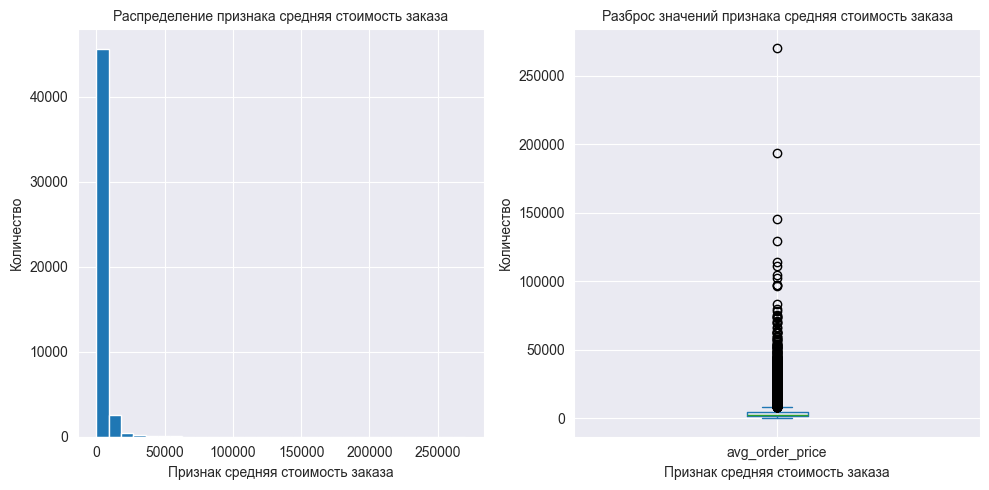

In [31]:
hist_num(data_merge_group['avg_order_price'], 'Распределение признака средняя стоимость заказа', 'Разброс значений признака средняя стоимость заказа', 'Признак средняя стоимость заказа')

Судя по всему в датасете есть небольшое количество значений выше 200 тыс. рублей. Отменитим это как анамалию и удалим эти данные:

In [32]:
data_merge_group = data_merge_group[data_merge_group['avg_order_price']<20000]

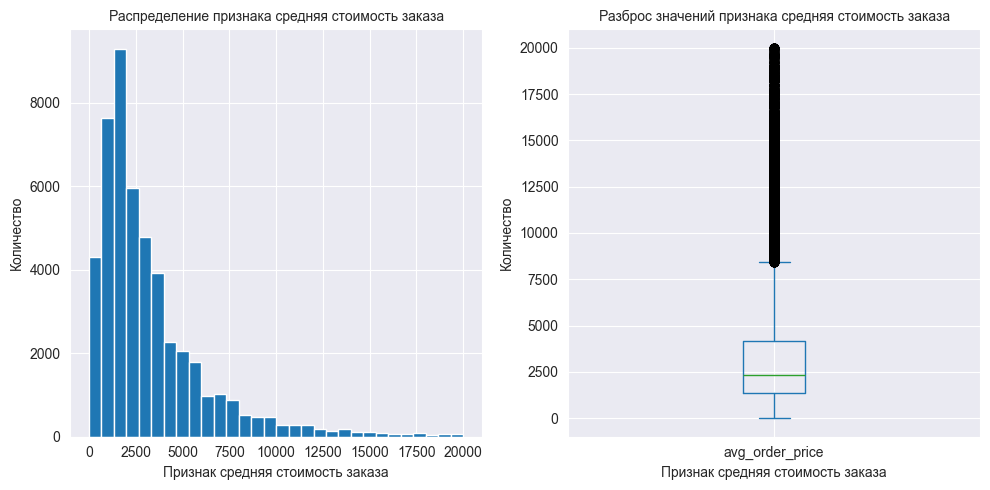

In [33]:
hist_num(data_merge_group['avg_order_price'], 'Распределение признака средняя стоимость заказа', 'Разброс значений признака средняя стоимость заказа', 'Признак средняя стоимость заказа')

In [34]:
data_merge_group.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48355 entries, 0 to 49848
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   client_id                   48355 non-null  int64         
 1   target                      48355 non-null  int64         
 2   client_type                 48355 non-null  object        
 3   avg_order_price             48355 non-null  float64       
 4   avg_item_price              48355 non-null  float64       
 5   avg_quantity                48355 non-null  float64       
 6   avg_count_event             48355 non-null  float64       
 7   avg_days_send_purch         48355 non-null  float64       
 8   most_frequent_channel       48355 non-null  object        
 9   cat_value                   48355 non-null  object        
 10  date_max_order              48355 non-null  datetime64[ns]
 11  avg_days_to_next_order      48355 non-null  float64       


Отлично! Данные стали иметь более понятный вид на гистограммах. Из датасета исчезло всего около 500 значений, что не должно сказаться на предсказаниях. Исходя из гистограммы чаще всего средняя стоимость заказа составляет от 2 до 5 тысяч рублей. Реже - значения выше.

Изучим следующий признак - средняя стоимость предмета в заказе:

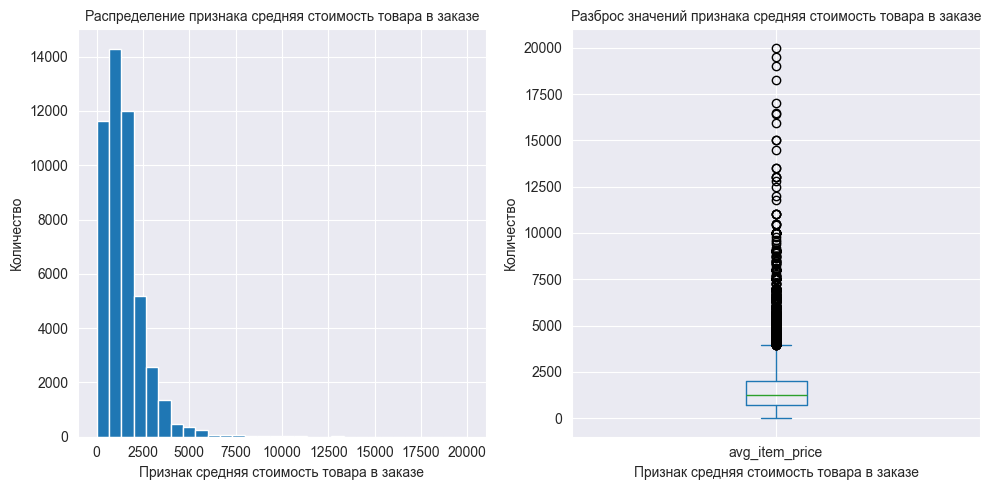

In [35]:
hist_num(data_merge_group['avg_item_price'], 'Распределение признака средняя стоимость товара в заказе', 'Разброс значений признака средняя стоимость товара в заказе', 'Признак средняя стоимость товара в заказе')

И опять есть выбросы свыше 6000 тысяч рублей. Уберем их:

In [36]:
data_merge_group = data_merge_group[data_merge_group['avg_item_price']<6000]

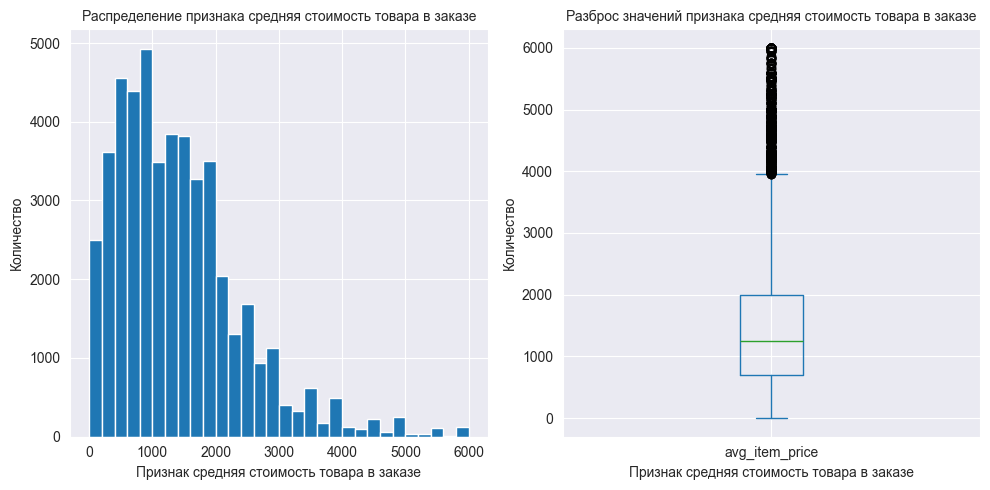

In [37]:
hist_num(data_merge_group['avg_item_price'], 'Распределение признака средняя стоимость товара в заказе', 'Разброс значений признака средняя стоимость товара в заказе', 'Признак средняя стоимость товара в заказе')

Отлично, выбросы исчезли и гистограмма теперь больше похожа на нормально. Как можно заметить чаще всего стоимость одного предмета в заказе варьируется от 500 рублей до 2,5 тысячи рублей.

Изучим следующий показатель - среднее количество предметов в заказе:

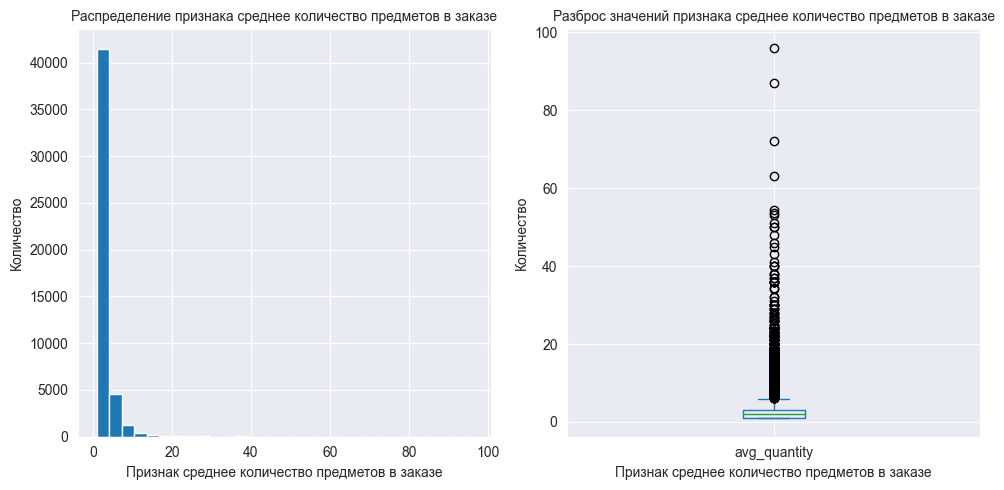

In [38]:
hist_num(data_merge_group['avg_quantity'], 'Распределение признака среднее количество предметов в заказе', 'Разброс значений признака среднее количество предметов в заказе', 'Признак среднее количество предметов в заказе')

И опять, есть выбросы. Значения выше 15 почти не встречаются. Но есть клиенты со значением выше 80. Удалим все, что выше 15.

In [39]:
data_merge_group = data_merge_group[data_merge_group['avg_quantity']<15]

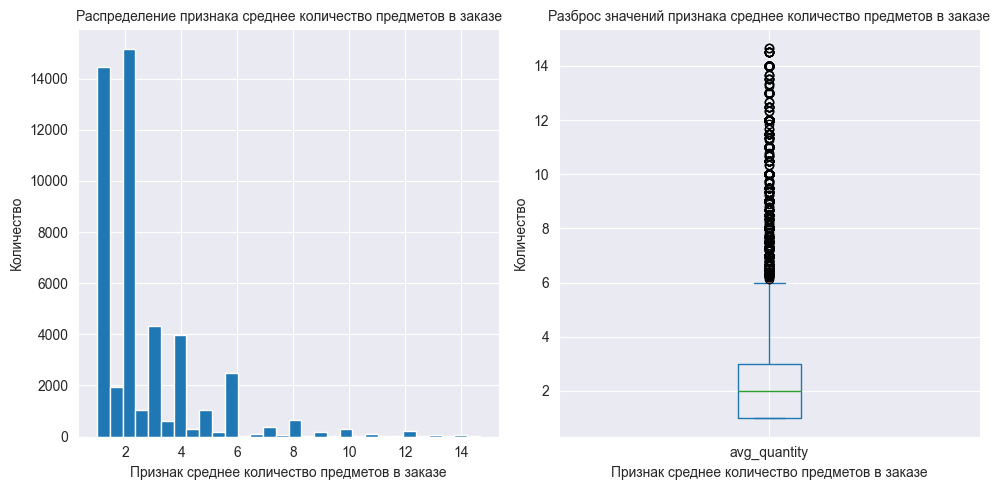

In [40]:
hist_num(data_merge_group['avg_quantity'], 'Распределение признака среднее количество предметов в заказе', 'Разброс значений признака среднее количество предметов в заказе', 'Признак среднее количество предметов в заказе')

Отлмчно! Чаще в заказах бывает 1 или 3 предмета - реже остальные значения.

Теперь изучим среднее количество событий до заказа:

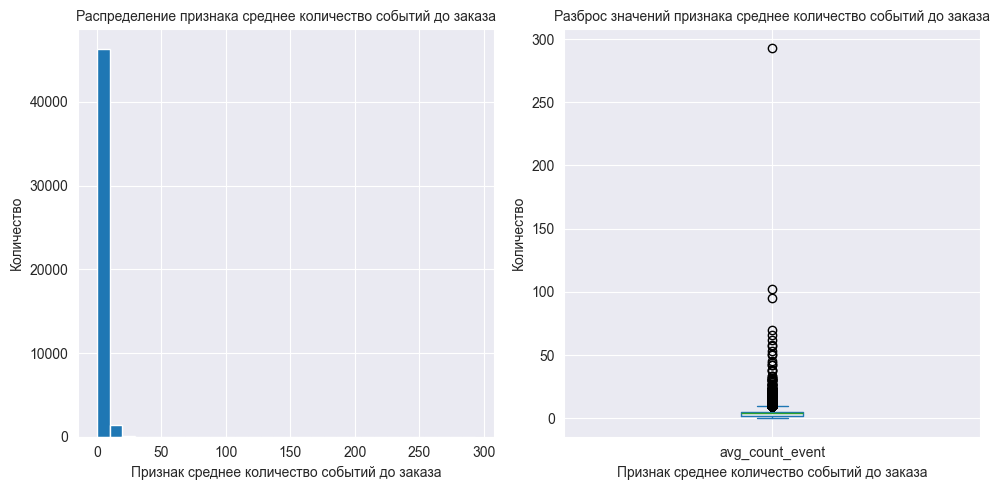

In [41]:
hist_num(data_merge_group['avg_count_event'], 'Распределение признака среднее количество событий до заказа', 'Разброс значений признака среднее количество событий до заказа', 'Признак среднее количество событий до заказа')

Как видно из гистограммы - значений, которые превышают 15 почти нет. Но есть аномальные значения, превышающие значение - 200. Удалим все, что ниже 15:

In [42]:
data_merge_group = data_merge_group[data_merge_group['avg_count_event']<15]

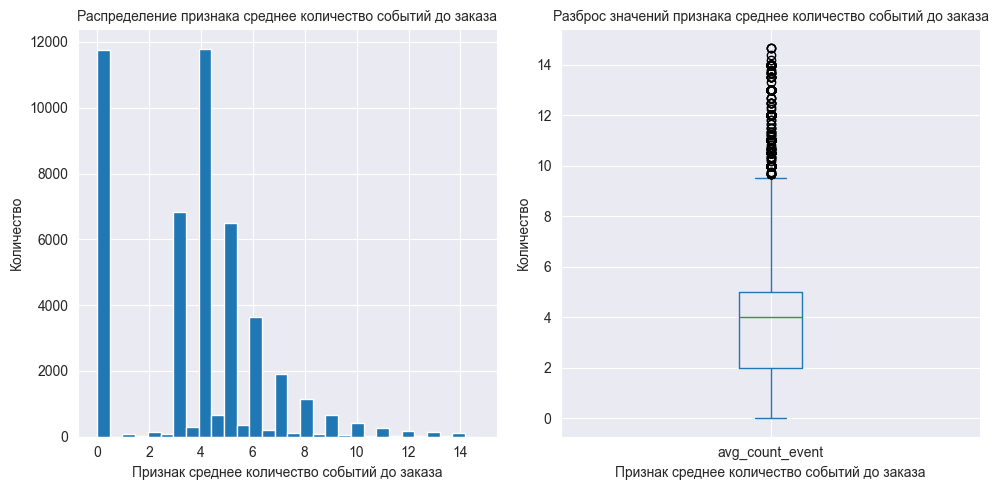

In [43]:
hist_num(data_merge_group['avg_count_event'], 'Распределение признака среднее количество событий до заказа', 'Разброс значений признака среднее количество событий до заказа', 'Признак среднее количество событий до заказа')

Отлично, по гистограмме можно отметить, что люди также часто заказывали в тот же день, как через четыре дня после уведомления. Остальные значения - реже.

Исследуем, наконец, среднее количество дней до следующего заказа

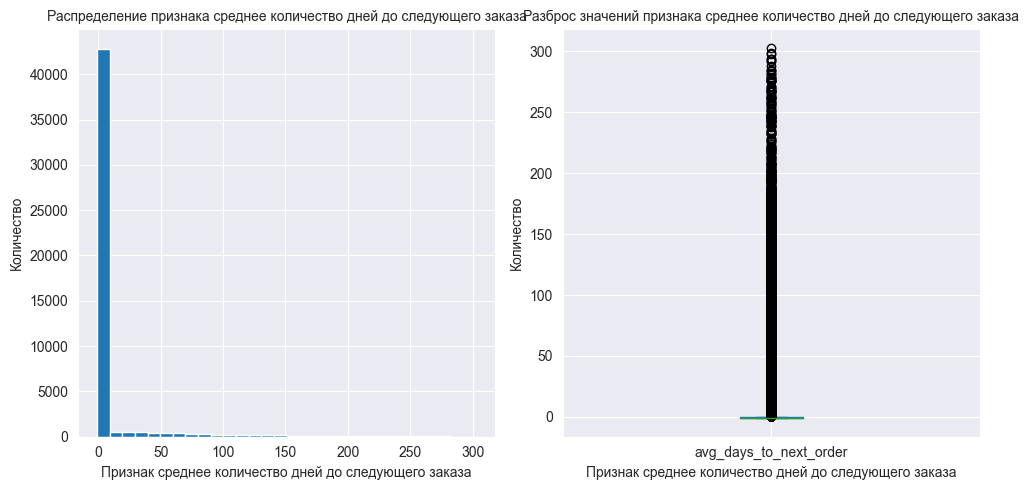

In [44]:
hist_num(data_merge_group['avg_days_to_next_order'], 'Распределение признака среднее количество дней до следующего заказа', 'Разброс значений признака среднее количество дней до следующего заказа', 'Признак среднее количество дней до следующего заказа')

Наша заглушка работает и перехватывает на себя большую часть, перенастроим, исключив это значение:

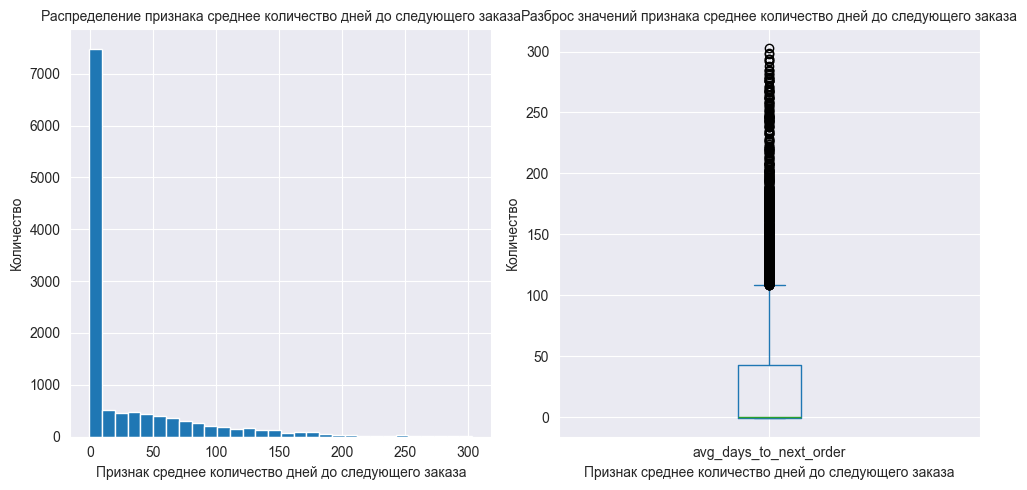

In [45]:
hist_num(data_merge_group[data_merge_group['avg_days_to_next_order']>-1]['avg_days_to_next_order'], 'Распределение признака среднее количество дней до следующего заказа', 'Разброс значений признака среднее количество дней до следующего заказа', 'Признак среднее количество дней до следующего заказа')

Отлично! Значений меньше 210 почти нет. Исключим все, что превышает это значение.

In [46]:
data_merge_group = data_merge_group[data_merge_group['avg_days_to_next_order']<210]

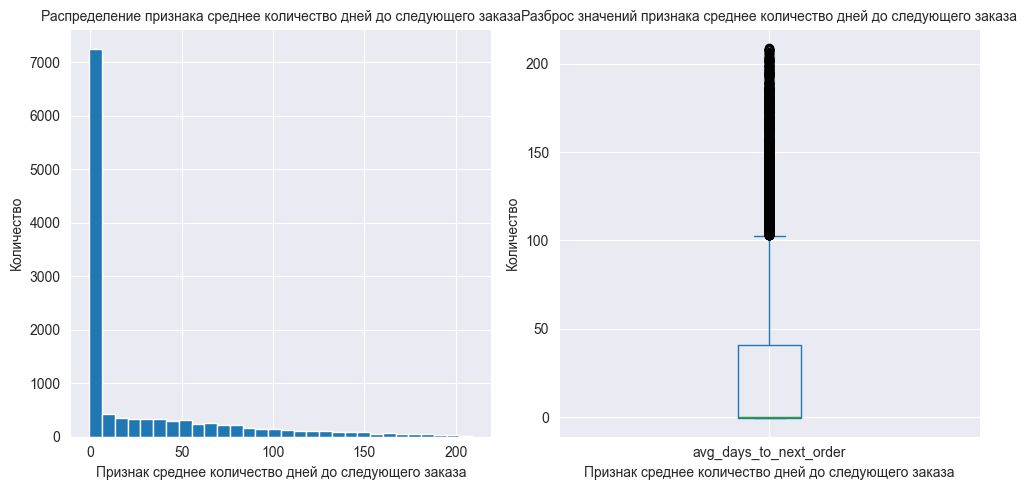

In [47]:
hist_num(data_merge_group[data_merge_group['avg_days_to_next_order']>-1]['avg_days_to_next_order'], 'Распределение признака среднее количество дней до следующего заказа', 'Разброс значений признака среднее количество дней до следующего заказа', 'Признак среднее количество дней до следующего заказа')

Чаще заказ был в тот же день, и чем больше проходило дней, тем реже человек мог повторить заказ.

Исследуем последний количественный признак - количество дней с последнего заказа:

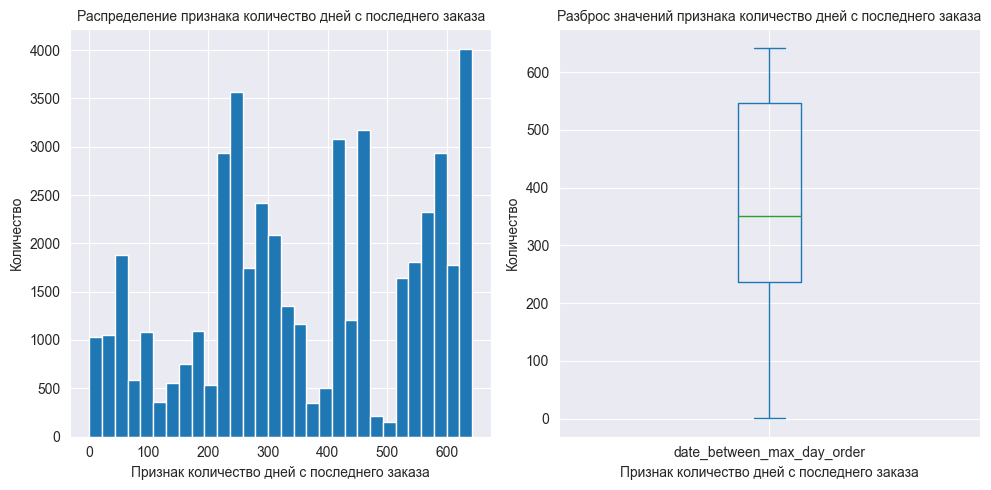

In [48]:
hist_num(data_merge_group['date_between_max_day_order'], 'Распределение признака количество дней с последнего заказа', 'Разброс значений признака количество дней с последнего заказа', 'Признак количество дней с последнего заказа')

Наконец-то мы получили гистограмму без выбросов. Значения по количеству дней варьируются между 250 и 600. Больше всего значений в датасете с информацией о количестве свыше 600 дней.

Приступим к исследованию качественных признаков.

Начнем с информации о типе клиента. Но пред этим объединим обратно наши датасеты, что вернуть таргет со значением 1.

In [49]:
data_merge_group = pd.concat([data_merge_group, data_merge_group_with])

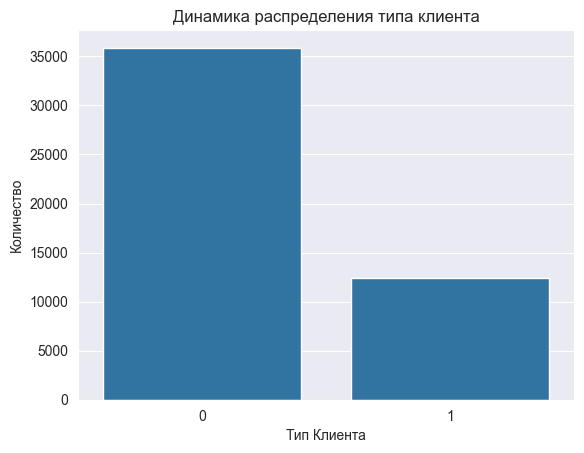

In [50]:
c = sns.countplot(data = data_merge_group, x='client_type' )
c.set_xlabel('Тип Клиента')
c.set_ylabel('Количество')
c.set_title('Динамика распределения типа клиента')
plt.show()

25% клиентов из датасета возвращались и повторяли заказ. А для 75% клиентов - это был первый и последний заказ.

Изучим столбец с информацией о тип сообщения:

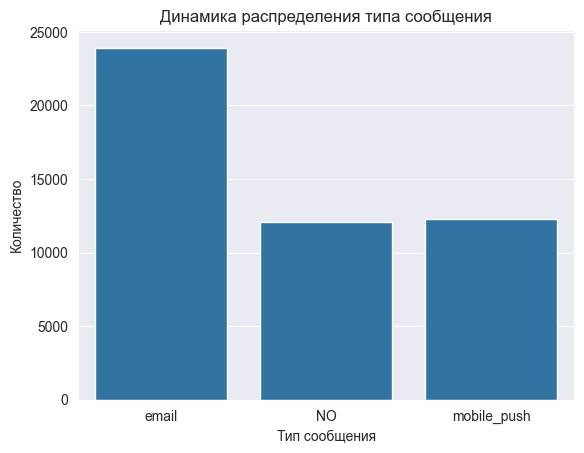

In [51]:
c = sns.countplot(data = data_merge_group, x='most_frequent_channel' )
c.set_xlabel('Тип сообщения')
c.set_ylabel('Количество')
c.set_title('Динамика распределения типа сообщения')
plt.show()

50% всех клиентов получили уведомление через почту. Можем изучить как распределяется наш целевой признак в зависимости от типа сообщения:

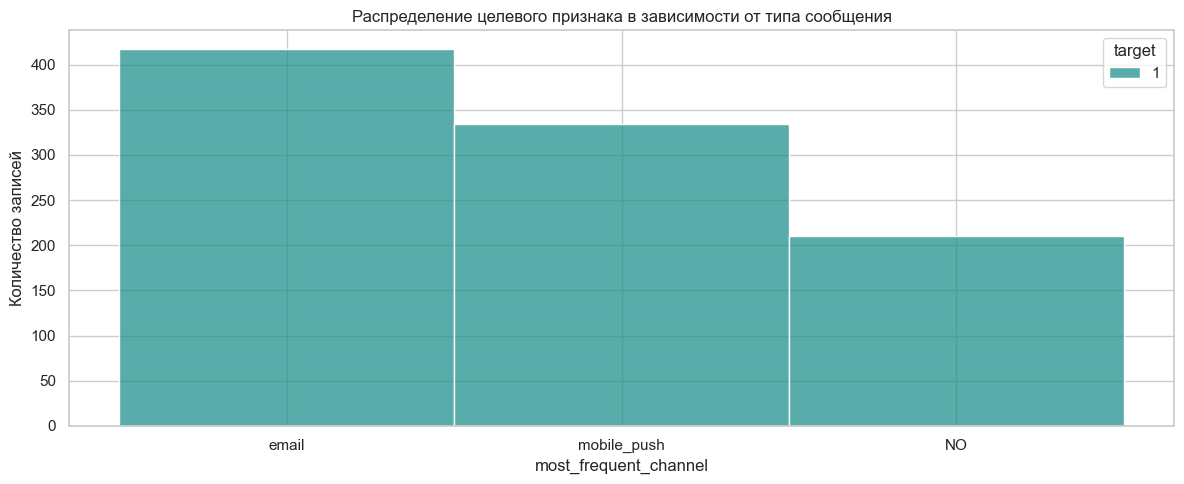

In [52]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 5))

feature = "most_frequent_channel"
title = "Распределение целевого признака в зависимости от типа сообщения"

sns.histplot(data=data_merge_group[data_merge_group['target']==1], x=feature, hue="target", multiple="stack", ax=ax, palette="viridis")
ax.set_title(title)
ax.set_xlabel(feature)
ax.set_ylabel("Количество записей")

plt.tight_layout()
plt.show()

В таргете нет дисбланса по типу сообщения. Больше всего сообщений пользователи с целевым признаком со значением 1 - получали по email. Чуть реже через мобильное приложение, а еще реже без информации о типе сообщения.

Исследуем последним столбец с информацией о категории:

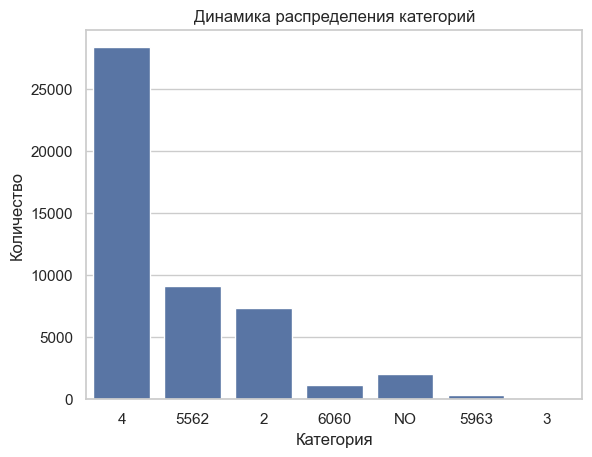

In [53]:
c = sns.countplot(data = data_merge_group, x='cat_value' )
c.set_xlabel('Категория')
c.set_ylabel('Количество')
c.set_title('Динамика распределения категорий')
plt.show()

Больше всего записей с информацией c категорией 4, более 50%. Примерно на одном уровне - 15% составляют категории 5562 и 2. Есть 3 записи с категорией 3. Они имееют нулевой таргет, поэтому зачищать их не будем.

In [54]:
data_merge_group[data_merge_group['cat_value']=='3']

,client_id,target,client_type,avg_order_price,avg_item_price,avg_quantity,avg_count_event,avg_days_send_purch,most_frequent_channel,cat_value,date_max_order,avg_days_to_next_order,date_between_max_day_order
21197,1515915625503627622,0,1,2596.000000,275.200000,6.0,6.0,1.0,email,3,2022-11-10,-0.500000,464
40700,1515915625759495104,0,1,3665.666667,3665.666667,1.0,4.0,2.0,mobile_push,3,2023-06-03,-0.333333,259
45126,1515915625862933230,0,1,918.000000,124.500000,6.0,8.0,1.0,mobile_push,3,2022-11-15,-0.333333,459


Итак на этапе исследования данных были изучены качественные и количественные признаки.

Перед изучением количественных признаков мы отделили таргет со значением "1", чтоб случайно не удалить и так редкий целевой признак.

По исследованию гистограмм и ящиков с усами было установлено, что чаще всего средняя стоимость заказа составляет от 2 до 5 тысяч рублей. Реже - значения выше. Также чаще всего стоимость одного предмета в заказе варьируется от 500 рублей до 2,5 тысячи рублей. Также в заказах бывает 1 или 3 предмета - реже остальные значения. По гистограмме с информацией об количестве дней с момента сообщения до покупки можно заметить, что люди также часто заказывали в тот же день, как через четыре дня после уведомления. Остальные значения - реже. Исследуя информацию о повторном заказе было установлено, что чаще заказ был в тот же день, и чем больше проходило дней, тем реже человек мог повторить заказ. Наконец, изучая информацию о количестве дней с момента последнего заказа - значения по количеству дней варьируются между 250 и 600. Больше всего значений в датасете с информацией о количестве свыше 600 дней.

Далее были исследованы качественные показатели. Было выявлено, что 25% клиентов из датасета возвращались и повторяли заказ. А для 75% клиентов - это был первый и последний заказ. 50% всех клиентов получили уведомление через почту, а больше всего сообщений пользователи с целевым признаком со значением 1 - получали по email. Чуть реже через мобильное приложение, а еще реже без информации о типе сообщения. И, наконец, изучая категории было установлено, что больше всего записей с информацией c категорией 4, более 50%. Примерно на одном уровне - 15% составляют категории 5562 и 2. Есть 3 записи с категорией 3. Они имееют нулевой таргет, поэтому зачищать их не будем.

Можно приступать к корреляционному анализу.



## 5. Корреляционный анализ

Построим матрицу корреляции:

In [55]:
corr_matrix = data_merge_group.drop(['client_id', 'client_type', 'most_frequent_channel', 'cat_value', 'date_max_order'], axis=1).corr()

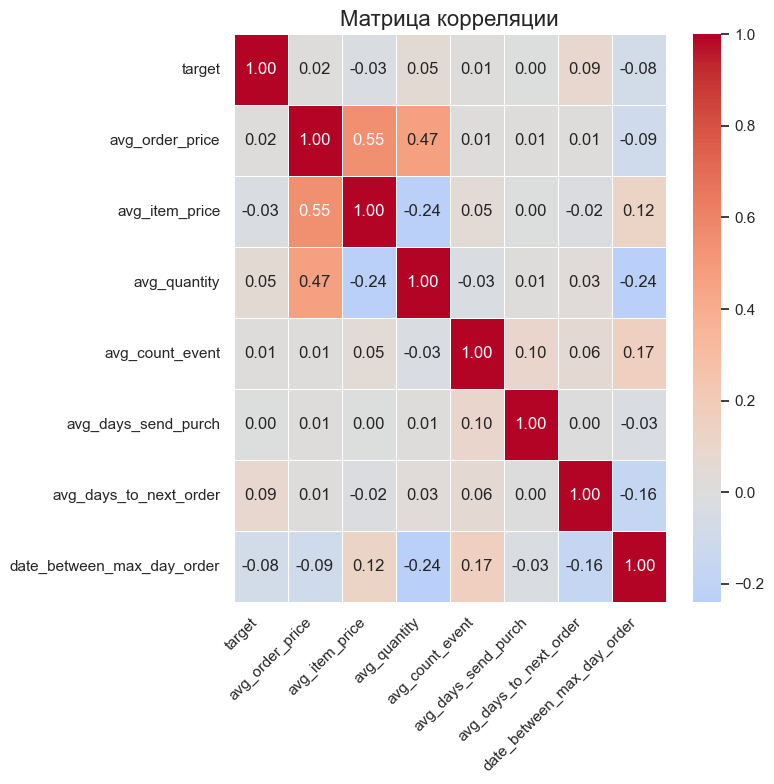

In [56]:
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, center=0)
plt.title('Матрица корреляции', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Таким образом, исходя из матрицы корреляции можно отметить, что мультиколлиниарность между признаками - отстствует.

Присутствует умеренная зависимость между стоимостью одного предмета в заказе и средней стоимостью заказа (0,55). Оно и понятно. Также есть умеренная зависимость между средней стоимостью заказа и средним количеством предметов в заказе (0,47) - и это тоже понятно и логично. Остальные корреляции не так заметны и влияют друг на друга.

Можно отметить, что больше всего на таргет влияет среднее количество дней до следующего заказа и отрицательно виляет количество дней с момента последнего заказа.

Также следует отметить, что есть отрицательная корреляция между средней стоимостью предмета в заказе и количеством. Тоже логично, чем дороже покупка - тем меньше предметов будет в заказе. Среднее количество также отрицательно виляет на количество дней с момента последнего заказа.

Можно приступать к созданию пайплайна.

## 6. Создадние пайплайна

Для начала разделим наши данные на валидационную и тренировочные выборки:

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(
    data_merge_group.drop(['client_id','target', 'date_max_order'], axis=1),
    data_merge_group[ 'target'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = data_merge_group['target'])

print(X_train.shape, X_valid.shape)
print(LINE_1)
y_train.shape, y_valid.shape

(36240, 10) (12081, 10)
-----------------------------------------------------------------------------------------------------------------------------


((36240,), (12081,))

Создадим переменную для стратификации данных:

In [58]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Начнем создавать наш пайплайн. Разделим колонки:

In [59]:
ohe_columns = ['client_type', 'most_frequent_channel']
ord_columns = ['cat_value']
num_columns = ['avg_order_price', 'avg_item_price',
               'avg_quantity', 'avg_count_event', 'avg_days_send_purch', 'date_between_max_day_order', 'avg_days_to_next_order']

Создадим пайплайн и пропишем большое количество моделей для поиска гиперпараметров:

In [60]:
ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe',
                SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')
            ),
            (
                'ohe',
                OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
            )
        ]
    )
ord_pipe = Pipeline([
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ])
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])


param_grid = [

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
        'models__penalty': ['l1', 'l2'],
        'models__C': range(1, 10),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [3, 5, 7, 9],
        'models__weights': ['uniform', 'distance'],  # Uniform or weighted distance
        'models__p': [1, 2],  # Manhattan (p=1) or Euclidean (p=2) distance
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300],
        'models__max_depth': range(3, 10),
        'models__learning_rate': [0.01, 0.1, 0.2],
        'models__subsample': [0.7, 0.8, 1.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__C': [0.1, 1, 10],  # Regularization parameter
        'models__kernel': ['linear', 'poly', 'rbf'],  # Kernel type
        'models__gamma': ['scale', 'auto'],  # Kernel coefficient
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True)],
        'models__depth': range(3, 10),
        'models__learning_rate': [0.01, 0.1, 0.2],
        'models__iterations': [100, 200, 300],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },  # Missing comma fixed here
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__n_estimators': [100, 200, 300],
        'models__max_depth': range(3, 10),
        'models__max_features': ['auto', 'sqrt', 'log2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300],
        'models__learning_rate': [0.01, 0.1, 0.2],
        'models__max_depth': range(3, 10),
        'models__subsample': [0.7, 0.8, 1.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [ExtraTreesClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__n_estimators': [100, 200, 300],
        'models__max_depth': range(3, 10),
        'models__max_features': ['auto', 'sqrt', 'log2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }

]

Таким образом, на этапе создания пайплайна данные были разделены на обучающую и валидационную выборки. Создан пайплайн с большим количеством моделей для подбора гиперпараметров.

Можно приступать к обучению модели.

## 7. Обучение моделей

Подберем модели и гипперпараметры через RandomizedSearchCV:

In [61]:
grid_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    n_iter=50,
    cv=stratified_cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=45, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(fill_value='unknown',
                                                                                                              strategy='constant')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [ExtraTreesClassifier(class_weight='balanced',
                                                                         random_state=45)],
                                         'models__max_depth': range(3, 10),
                                         'models__max_features': ['auto',
                                                                  'sqrt',
                                                                  'log2'],
                                         'models__n_estimators': [100, 200,
                                                                  300],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=45, scoring='roc_auc')

In [62]:
result_data = pd.DataFrame(grid_search.cv_results_)
display(result_data[['rank_test_score','std_test_score', 'param_models', 'mean_test_score', 'params']].sort_values('rank_test_score').head(10))
print('Лучшая модель и её параметры: \n\n', grid_search.best_estimator_)
print('Параметры лучшей модели:', grid_search.best_params_)
print('Метрика лучшей модели по кросс-валидации на обучающих данных:', grid_search.best_score_)

,rank_test_score,std_test_score,param_models,mean_test_score,params
12,1,0.017663,GradientBoostingClassifier(random_state=45),0.716611,"{'preprocessor__num': MinMaxScaler(), 'models_..."
46,2,0.017165,GradientBoostingClassifier(random_state=45),0.716514,"{'preprocessor__num': StandardScaler(), 'model..."
17,3,0.017732,GradientBoostingClassifier(random_state=45),0.714411,"{'preprocessor__num': MinMaxScaler(), 'models_..."
31,4,0.018783,LGBMClassifier(random_state=45),0.712668,"{'preprocessor__num': MinMaxScaler(), 'models_..."
6,5,0.020281,LGBMClassifier(random_state=45),0.711471,"{'preprocessor__num': 'passthrough', 'models__..."
20,6,0.019383,LGBMClassifier(random_state=45),0.710962,"{'preprocessor__num': StandardScaler(), 'model..."
26,7,0.019982,<catboost.core.CatBoostClassifier object at 0x...,0.710205,"{'preprocessor__num': 'passthrough', 'models__..."
39,8,0.015874,<catboost.core.CatBoostClassifier object at 0x...,0.709369,"{'preprocessor__num': StandardScaler(), 'model..."
19,9,0.017586,<catboost.core.CatBoostClassifier object at 0x...,0.707851,"{'preprocessor__num': MinMaxScaler(), 'models_..."
10,10,0.021986,LGBMClassifier(random_state=45),0.707103,"{'preprocessor__num': StandardScaler(), 'model..."


Лучшая модель и её параметры: 

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['client_type',
                                                   'most_frequent_channel']

In [63]:
y_pred_valid = grid_search.best_estimator_.predict_proba(X_valid)[:,1]
roc_auc_pred = roc_auc_score(y_valid, y_pred_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_pred}')

ROC-AUC на валидационной выборке: 0.7109513554598429


Метрика ROC-AUC на валидационных данных почти не отличается от данной метрики на валидационной (0.716 против 0.711). Отлично! Можно приступать к построению матрицы ошибок

In [64]:
y_pred = grid_search.predict(X_valid)

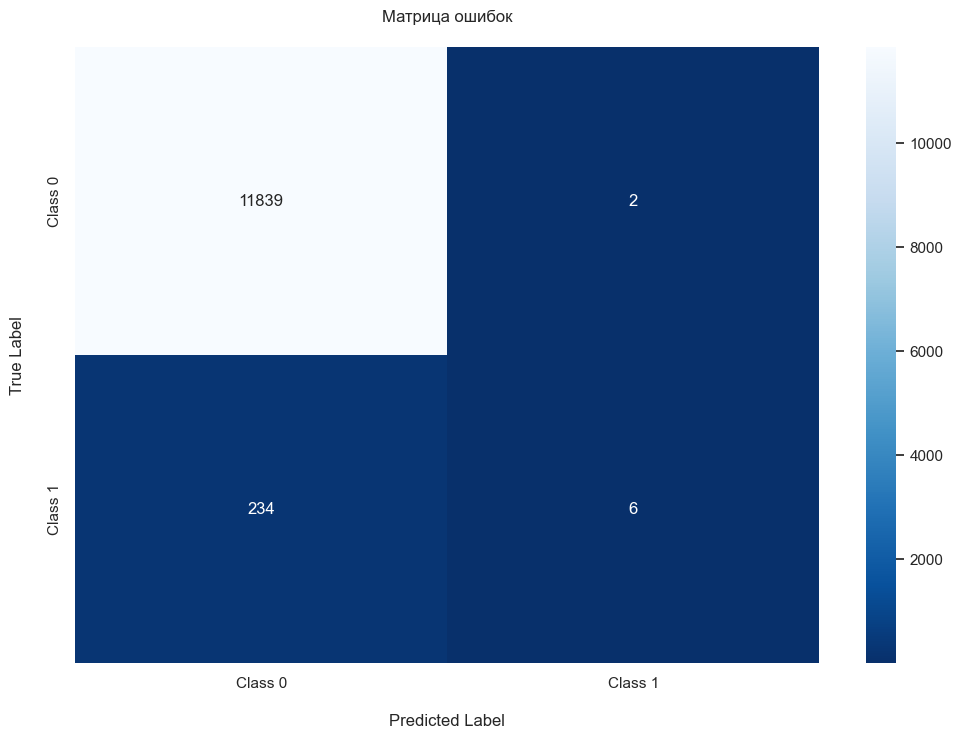

In [65]:
cm = confusion_matrix(y_valid, y_pred)

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('\nPredicted Label')
plt.ylabel('True Label\n')
plt.title('Матрица ошибок\n');

Таким образом, на первый взгляд, несмотря на неплохую метрику, составляющую 0.71 (что говорит об умеренном умении модели предсказывать классы), можно отметить, по матрице ошибок, что модель ошибочно предсказала 234 клиента с целевым признаком из 240. Это очень плохо и связано это скорее всего с дисбалансом классов. В качестве альтернативы используем метрику recall, которая покажет долю верно предсказанных положительных случаев, как альтернативное решение.

In [66]:
grid_search_recall = RandomizedSearchCV(
    pipe_final,
    param_grid,
    n_iter=50,
    cv=stratified_cv,
    scoring='recall',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

grid_search_recall.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=45, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(fill_value='unknown',
                                                                                                              strategy='constant')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [ExtraTreesClassifier(class_weight='balanced',
                                                                         random_state=45)],
                                         'models__max_depth': range(3, 10),
                                         'models__max_features': ['auto',
                                                                  'sqrt',
                                                                  'log2'],
                                         'models__n_estimators': [100, 200,
                                                                  300],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=45, scoring='recall')

In [67]:
result_data_recall = pd.DataFrame(grid_search_recall.cv_results_)
display(result_data_recall[['rank_test_score','std_test_score', 'param_models', 'mean_test_score', 'params']].sort_values('rank_test_score').head(10))
print('Лучшая модель и её параметры: \n\n', grid_search_recall.best_estimator_)
print('Параметры лучшей модели:', grid_search_recall.best_params_)
print('Метрика лучшей модели по кросс-валидации на обучающих данных:', grid_search_recall.best_score_)

,rank_test_score,std_test_score,param_models,mean_test_score,params
48,1,0.041805,"LogisticRegression(random_state=45, solver='li...",0.617165,"{'preprocessor__num': RobustScaler(), 'models_..."
38,2,0.070346,"SVC(class_weight='balanced', random_state=45)",0.581284,"{'preprocessor__num': MinMaxScaler(), 'models_..."
40,3,0.031474,DecisionTreeClassifier(random_state=45),0.545010,"{'preprocessor__num': MinMaxScaler(), 'models_..."
4,4,0.024665,"ExtraTreesClassifier(class_weight='balanced', ...",0.535354,"{'preprocessor__num': 'passthrough', 'models__..."
8,5,0.042611,"SVC(class_weight='balanced', random_state=45)",0.526983,"{'preprocessor__num': StandardScaler(), 'model..."
34,6,0.059542,DecisionTreeClassifier(random_state=45),0.490939,"{'preprocessor__num': 'passthrough', 'models__..."
7,7,0.034057,"ExtraTreesClassifier(class_weight='balanced', ...",0.471552,"{'preprocessor__num': 'passthrough', 'models__..."
32,8,0.018769,DecisionTreeClassifier(random_state=45),0.429923,"{'preprocessor__num': MinMaxScaler(), 'models_..."
13,9,0.073986,DecisionTreeClassifier(random_state=45),0.428697,"{'preprocessor__num': StandardScaler(), 'model..."
1,10,0.028636,RandomForestClassifier(class_weight='balanced'...,0.337031,"{'preprocessor__num': MinMaxScaler(), 'models_..."


Лучшая модель и её параметры: 

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['client_type',
                                                   'most_frequent_channel']

In [68]:
y_pred_recall = grid_search_recall.best_estimator_.predict(X_valid)

In [73]:
recall_valid = recall_score(y_valid, y_pred_recall)
print(f'Recall на валидационной выборке: {recall_valid}')

ROC-AUC на валидационной выборке: 0.5916666666666667


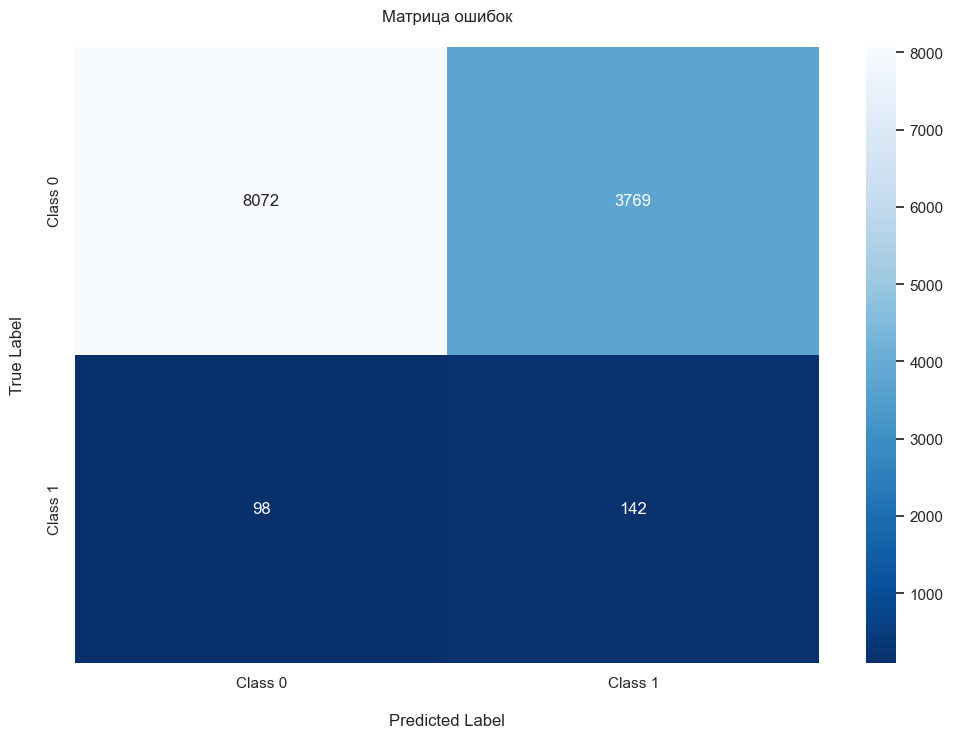

In [69]:
cm = confusion_matrix(y_valid, y_pred_recall)

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('\nPredicted Label')
plt.ylabel('True Label\n')
plt.title('Матрица ошибок\n');

В данном случае у нас для предсказания возврата клиентов ситуация получше.

Высокий FP: Модель слишком часто предсказывает возврат клиентов, которые в действительности не возвращаются. Это ведет к большому числу лишних уведомлений (3769), что может быть неэффективно и раздражать клиентов. Но в то же время модель предсказала 142 клиента, которые вернутся, что уже хорошо.
Какую из этих двух моделей выбирать будет зависить от приоритетов бизнеса. Что важнее: уловить как можно больше вернувшихся клиентов (даже ценой большого числа ненужных уведомлений) или минимизировать количество лишних уведомлений (даже если придется пожертвовать некоторыми потенциальными клиентами). В случае, когда нужно подобрать большее количество клиентов, которые точно вернутся - лучше использовать метрику recall.

Приступим к оценке важности признаков.

## 8. Оценка важности признаков

In [76]:
import shap
best_model = grid_search.best_estimator_.named_steps['models']
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

# Подготавливаем данные для SHAP. Трансформируем X_train и X_test
X_train_transformed = preprocessor.transform(X_train)
X_valid_transformed = preprocessor.transform(X_valid)


# Визуализация# Функция для получения имен признаков из ColumnTransformer
def get_feature_names(transformer, input_features=None):
    """
    Получение имен признаков из ColumnTransformer.
    """
    output_features = []

    for name, pipe, features in transformer.transformers_:
        if name == 'remainder':
            # Если 'remainder', добавляем неизменные признаки
            output_features.extend(input_features[features])
        else:
            # Для каждого трансформера получаем имена
            if hasattr(pipe, 'get_feature_names_out'):
                feature_names = pipe.get_feature_names_out(features)
            elif hasattr(pipe, 'get_feature_names'):
                feature_names = pipe.get_feature_names(features)
            else:
                feature_names = features  # Если трансформер не изменяет имена, оставляем как есть
            output_features.extend(feature_names)

    return output_features
feature_names = get_feature_names(preprocessor, input_features=X_train.columns.tolist())

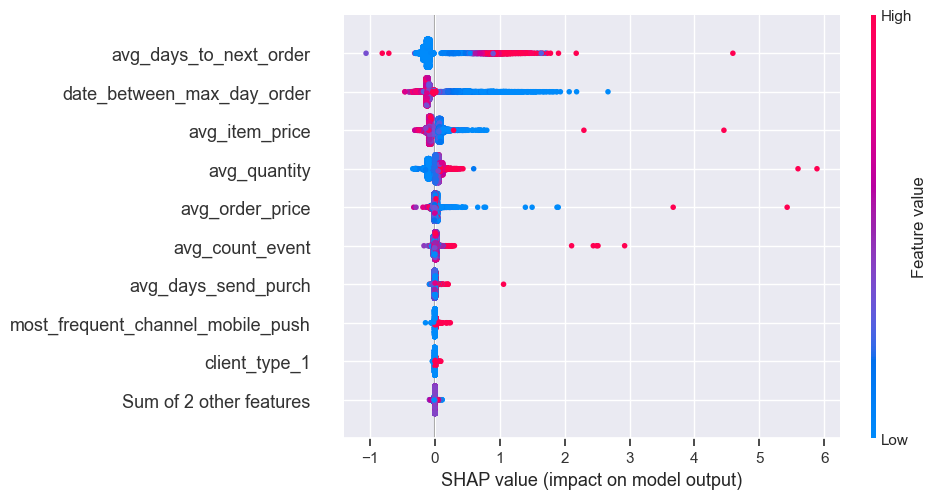

In [82]:
explainer = shap.TreeExplainer(best_model, feature_names=feature_names)
shap_values = explainer(X_valid_transformed)
shap.plots.beeswarm(shap_values)

Таким образом, на основание SHAP можно сказать, что количество дней до следующего заказа оказывает большее виляение на результат модели. Чем больше дней до следующего заказа тем выше вероятность, что клиент вернется. Также можно отметить, что большое влияние оказывает дней между последним заказом и датой выгрузки данных. Это говорит о том, что чем больше дней прошло, тем меньше шанс того, что клиент вернется.

Также следует одним из важных признаков отметить среднюю цену одного продукта. Чем ниже стоимость купленного товара, тем больше шанс, что клиент вернется после уведомления или письма. Это может говорить о том, что большие покупки чаще разовые, и клиент скорее всего не вернется.

Остальные признаки не оказывают такого влияния. Соотвественно можно также говорить и о том, что наши модели можно улучшить лучшим подбором признаков для обучения моделей.

Данный SHAP был построен на roc-auc, но в предсказании клиентов, которые действительно вернутся была лучше модель на метрике recall. Предлагается заказчику пересмотреть метрику и улучшить модель с метрикой recall.

### Общий вывод

В нашем распоряжении были данные компании с информацией о покупках клиентов по дням и по товарам, данные о рассылках, которые были отправлены клиентам и целевой признак о факте совершения покупки в целевом периоде. Наша цель была проанализировать эти данные и при помощи моделей машинного обучения и решить задачу: предсказать вероятность покупки в течение 90 дней.

На этапе загрузки данных - данные были загружены и изучены. На первый взгляд проблем с ними нет. Разве что есть пропуски в колонке с информацией о категориях.

На этапе предобработки данных - нужные данные были преобразованы в предключевые признаки для дальнейшего обучения моделей. Были добавлены столбцы с информацией о первой категории то покупке, средней цене заказа, сумме заказов, количестве товаров в заказах, количестве дней до следующего заказа, начиная с предыдущего и тип клиента.

На этапе объединения данных были слиты все три датасета и получены новые признаки. Тип клиента, средняя стоимость заказа, средняя стоимость одной еденицы товара в заказе, среднее количество событий с отправки уведомления до заказа, среднее количество дней с отправки уведомления до заказа, наиболее частый канал направки уведомления, наиболее частая первая категория в заказе, количество дней до следующего заказа и, наконец, количество дней между между последним заказом и датой выгрузки данных. В качестве заполнения пропусков был выбран путь заполнения заглушками. В данном случае это заполнение именно отсутствующей информацией по клиенту, что не должно сказать на итоговом обучении.

На этапе исследования данных были изучены качественные и количественные признаки.

Перед изучением количественных признаков мы отделили таргет со значением "1", чтоб случайно не удалить и так редкий целевой признак.

По исследованию гистограмм и ящиков с усами было установлено, что чаще всего средняя стоимость заказа составляет от 2 до 5 тысяч рублей. Реже - значения выше. Также чаще всего стоимость одного предмета в заказе варьируется от 500 рублей до 2,5 тысячи рублей. Также в заказах бывает 1 или 3 предмета - реже остальные значения. По гистограмме с информацией об количестве дней с момента сообщения до покупки можно заметить, что люди также часто заказывали в тот же день, как через четыре дня после уведомления. Остальные значения - реже. Исследуя информацию о повторном заказе было установлено, что чаще заказ был в тот же день, и чем больше проходило дней, тем реже человек мог повторить заказ. Наконец, изучая информацию о количестве дней с момента последнего заказа - значения по количеству дней варьируются между 250 и 600. Больше всего значений в датасете с информацией о количестве свыше 600 дней.

Далее были исследованы качественные показатели. Было выявлено, что 25% клиентов из датасета возвращались и повторяли заказ. А для 75% клиентов - это был первый и последний заказ. 50% всех клиентов получили уведомление через почту, а больше всего сообщений пользователи с целевым признаком со значением 1 - получали по email. Чуть реже через мобильное приложение, а еще реже без информации о типе сообщения. И, наконец, изучая категории было установлено, что больше всего записей с информацией c категорией 4, более 50%. Примерно на одном уровне - 15% составляют категории 5562 и 2. Есть 3 записи с категорией 3. Они имееют нулевой таргет, поэтому зачищать их мы не стали.

На этапе корреляционного анализа было установлено, что присутствует умеренная зависимость между стоимостью одного предмета в заказе и средней стоимостью заказа (0,55). Оно и понятно. Также есть умеренная зависимость между средней стоимостью заказа и средним количеством предметов в заказе (0,47) - и это тоже понятно и логично. Остальные корреляции не так заметны и влияют друг на друга.

Можно отметить, что больше всего на таргет влияет среднее количество дней до следующего заказа и отрицательно виляет количество дней с момента последнего заказа.

Также следует отметить, что есть отрицательная корреляция между средней стоимостью предмета в заказе и количеством. Тоже логично, чем дороже покупка - тем меньше предметов будет в заказе. Среднее количество также отрицательно виляет на количество дней с момента последнего заказа.

На этапе обучения моделей для метрики roc-auc была выбрана модель GradientBoostingClassifier с гиперпараметрами: 'models__subsample': 0.7, 'models__n_estimators': 200, 'models__max_depth': 6, 'models__learning_rate': 0.01. Метрика получилась 0,71. Таким образом, на первый взгляд, несмотря на неплохую метрику, составляющую 0.71 (что говорит об умеренном умении модели предсказывать классы), можно отметить, по матрице ошибок, что модель ошибочно предсказала 234 клиента с целевым признаком из 240. Это очень плохо и связано это скорее всего с дисбалансом классов. В качестве альтернативы использовали метрику recall, которая покажет долю верно предсказанных положительных случаев, как альтернативное решение.

В случае с recall ситуация в плане предсказания клиентов - лучше.

Высокий FP: Модель слишком часто предсказывает возврат клиентов, которые в действительности не возвращаются. Это ведет к большому числу лишних уведомлений (3769), что может быть неэффективно и раздражать клиентов. Но в то же время модель предсказала 142 клиента, которые вернутся, что уже хорошо.
Какую из этих двух моделей выбирать будет зависеть от приоритетов бизнеса. Что важнее: уловить как можно больше вернувшихся клиентов (даже ценой большого числа ненужных уведомлений) или минимизировать количество лишних уведомлений (даже если придется пожертвовать некоторыми потенциальными клиентами). В случае, когда нужно подобрать большее количество клиентов, которые точно вернутся - лучше использовать метрику recall.

На этапе оценки важности признаков на основание построенного SHAP можно сказать, что количество дней до следующего заказа оказывает большее виляение на результат модели. Чем больше дней до следующего заказа тем выше вероятность, что клиент вернется. Также можно отметить, что большое влияние оказывает дней между последним заказом и датой выгрузки данных. Это говорит о том, что чем больше дней прошло, тем меньше шанс того, что клиент вернется.

Также следует одним из важных признаков отметить среднюю цену одного продукта. Чем ниже стоимость купленного товара, тем больше шанс, что клиент вернется после уведомления или письма. Это может говорить о том, что большие покупки чаще разовые, и клиент скорее всего не вернется.

Остальные признаки не оказывают такого влияния. Соотвественно можно также говорить и о том, что наши модели можно улучшить лучшим подбором признаков для обучения моделей.

Данный SHAP был построен на roc-auc, но в предсказании клиентов, которые действительно вернутся, была лучше модель на метрике recall.

Предлагается заказчику пересмотреть метрику и улучшить модель с метрикой recall.

